This notebook evaluates the probe on the set of test words (all polysemous senses)

In [98]:
from core.analysis import *
from core.metrics import *
from core.semcor_bert_pipeline import get_pos, save_embeds_with_wts, load_data
from scipy.stats import mode
import numpy as np
import pandas as pd
import json
import warnings
warnings.filterwarnings('ignore')

## Data Prep

Reading in experimental data to see which words to run the model on

In [97]:
with open('../data/stimuli.json') as f:
    db = json.load(f)

In [6]:
results = pd.read_csv('../data/approved_expt_results.csv')
incl_users = results['userID'].unique()

In [7]:
test_repeat_lem_cnt = get_lemma_counts(results, incl_users, db)
test_words = test_repeat_lem_cnt[test_repeat_lem_cnt['num_trials'] > 10]['lemma']

## Modeling

Compute F1 scores through cross validation

In [8]:
model_data = {}
test_stats = []
incorrect = []
for w in test_words:
    word, pos = w.split('_')
    word_data = load_data(word, pos, 'semcor')
    true_labels = word_data['sense_labels']
    random_labels = np.random.choice(true_labels, len(true_labels))
    most_common = mode(true_labels)
    maj_labels = [most_common[0][0]] * len(true_labels)
    pca_results = logistic_cv(w, sel_senses = [fb_to_local(s) for s in get_senses(db, w)], use_pca = True,
                               use_masc = False, delim = '_')

    model_results = logistic_cv(w, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                               use_masc = False, delim = '_')
    model_data[w] = model_results
    test_stats.append({"word": w, 'avg_f1': np.mean(model_results['f1']),
                         'avg_f1_pca': np.mean(pca_results['f1']),
                      'avg_f1_random': f1_score(true_labels, random_labels, average = 'weighted'),
                      'avg_f1_maj': f1_score(true_labels, maj_labels, average = 'weighted')})    
    incorrect.append(misclassified_sentences(model_results, model_results['incorrect_indices']))

Accuracies and F1 scores for Test Words for 5 fold Cross Validation 

In [9]:
model_perf = pd.DataFrame(test_stats).sort_values('avg_f1', ascending = False)

In [10]:
model_perf

,word,avg_f1,avg_f1_pca,avg_f1_random,avg_f1_maj
1,area_n,0.922816,0.913305,0.587714,0.655229
3,ask_v,0.904956,0.909774,0.505595,0.406448
12,raise_v,0.898952,0.842472,0.299354,0.210181
20,light_n,0.863464,0.812170,0.357120,0.325313
9,heart_n,0.835934,0.789240,0.266167,0.268262
24,man_n,0.826705,0.800340,0.598059,0.653590
22,point_n,0.818048,0.779114,0.255230,0.260856
18,glass_n,0.814986,0.669453,0.393985,0.424561
11,school_n,0.807611,0.815811,0.732605,0.781563
17,face_n,0.793446,0.782206,0.701405,0.715009


In [13]:
model_perf.mean()

word             0.000000e+00+4.940656e-324j
avg_f1            7.340292e-01+0.000000e+00j
avg_f1_pca        7.113190e-01+0.000000e+00j
avg_f1_random     4.068326e-01+0.000000e+00j
avg_f1_maj        3.809191e-01+0.000000e+00j
dtype: complex128

## Analysis of Classifier Performance

We plot F1 score with respect to entropy and number of senses

In [75]:
model_perf['Part of Speech'] = model_perf['word'].apply(lambda s: s.split("_")[1])
model_perf['Part of Speech'].replace({"n": "Noun", "v": "Verb"}, inplace = True)
model_perf

,word,avg_f1,avg_f1_pca,avg_f1_random,avg_f1_maj,Part of Speech
1,area_n,0.922816,0.913305,0.587714,0.655229,Noun
3,ask_v,0.904956,0.909774,0.505595,0.406448,Verb
12,raise_v,0.898952,0.842472,0.299354,0.210181,Verb
20,light_n,0.863464,0.812170,0.357120,0.325313,Noun
9,heart_n,0.835934,0.789240,0.266167,0.268262,Noun
24,man_n,0.826705,0.800340,0.598059,0.653590,Noun
22,point_n,0.818048,0.779114,0.255230,0.260856,Noun
18,glass_n,0.814986,0.669453,0.393985,0.424561,Noun
11,school_n,0.807611,0.815811,0.732605,0.781563,Noun
17,face_n,0.793446,0.782206,0.701405,0.715009,Noun


Average F1 score on polysemous items

In [77]:
np.mean(model_perf['avg_f1'])

0.7340292289538529

Adding the data from the homonymous stimuli

In [76]:
np.mean(list(model_perf['avg_f1']) + [1, 1, 1, 1, 0.962, 0.982])

0.7821487485250055

Reading in the entropy data

In [63]:
semcor_entropy = pd.read_csv('../data/expt_semcor_types_revised.csv')
semcor_entropy['word'] = semcor_entropy['Lemma'].apply(lambda l: l.replace('.', '_'))
with_entropy = model_perf.merge(semcor_entropy, on = 'word')

In [66]:
np.mean(with_entropy[with_entropy['entropy'] < 1.5]['avg_f1'])

0.7618612797638472

In [67]:
np.mean(with_entropy[with_entropy['entropy'] > 1.5]['avg_f1'])

0.6423132069888564

In [12]:
from adjustText import adjust_text

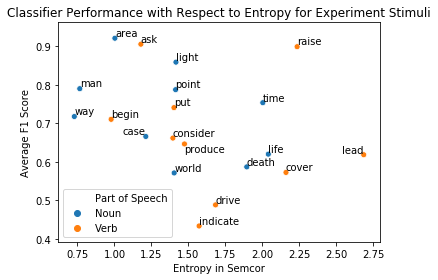

In [13]:
ent_f1 = sns.scatterplot(x = 'entropy', y = 'avg_f1', hue = 'Part of Speech', data = with_entropy)

texts = []
for x, y, s in zip(with_entropy['entropy'], with_entropy['avg_f1'], with_entropy['word'].apply(lambda s: s.split("_")[0])):
    texts.append(plt.text(x, y, s))

adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1, 1), expand_text=(1, 1))
plt.xlabel("Entropy in Semcor")
plt.ylabel("Average F1 Score")
plt.title("Classifier Performance with Respect to Entropy for Experiment Stimuli")
plt.tight_layout()
plt.savefig("../../results/figures/f1_entropy_expt.png")

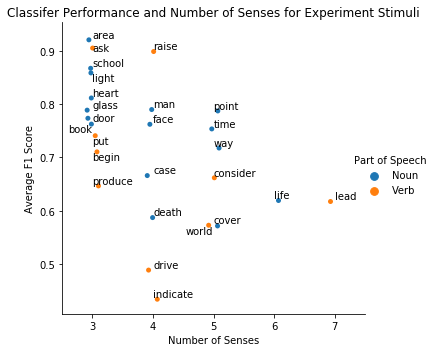

In [15]:
sns.catplot(x = 'num_senses', y = 'avg_f1', hue = 'Part of Speech', data = model_perf)
texts = []
for x, y, s in zip(model_perf['num_senses'] - 3, model_perf['avg_f1'], 
                   model_perf['word'].apply(lambda s: s.split("_")[0])): 
    texts.append(plt.text(x, y, s))

adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1, 1), expand_text=(1, 1))

plt.title("Classifer Performance and Number of Senses for Experiment Stimuli")
plt.xlabel("Number of Senses")
plt.ylabel("Average F1 Score")
plt.tight_layout()
plt.savefig("../../results/figures/f1_num_sense_expt")

## Confusion Matrices

We plot the results from the experiment with the cosine similarity of the BERT centroids, as well as the confusion matrices for the classification task. 

In [13]:
import seaborn as sns

In [14]:
from matplotlib.backends.backend_pdf import PdfPages

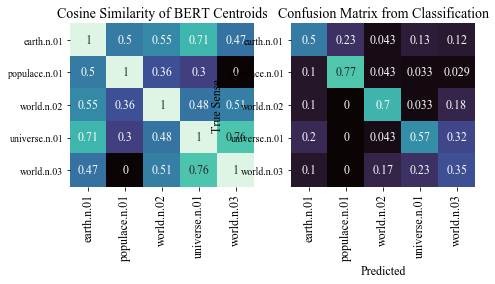

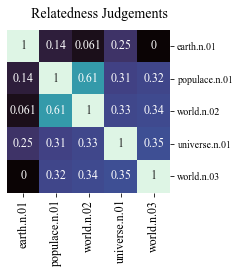

In [85]:
plt.rcParams["font.family"] = "Times New Roman"

confusion_matrices = {w: {} for w in test_words}
title_size = 14
text_size = 12

for w in test_words:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (3, 3))

    avg_reported = get_test_result_data(results, w, incl_users)
    senses = np.array([fb_to_local(s) for s in get_senses(db, w.replace('.', '_'))])
    cg = sns.clustermap(mtx_to_df(1 - avg_reported, senses), cmap = 'mako', annot = True, figsize = (4, 4),
                        
                           cbar_pos = None, vmin = 0, vmax = 1, annot_kws={"size": text_size})
    cg.fig.suptitle('Relatedness Judgements', y = 0.9, fontsize = title_size)
    cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xmajorticklabels(), fontsize = text_size)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    reordered_sense_indices = cg.dendrogram_row.reordered_ind

    word, pos = w.split("_")
    
    bert_cs, sense_names = cosine_sim_mtx(word, pos, sel_senses = senses,
                                         corpus = 'semcor', use_masc = False)
    bert_cs = normalize_cos_dist(bert_cs)
    bcs_fig = sns.heatmap(mtx_to_df(1 - bert_cs, senses, reorder = reordered_sense_indices),
                          ax = ax1, annot = True, cmap = 'mako', cbar = False,  vmin = 0, vmax = 1,
                          annot_kws={"size": text_size})
    bcs_fig.set_title("Cosine Similarity of BERT Centroids", fontsize = title_size)
    bcs_fig.set_xticklabels(bcs_fig.get_xmajorticklabels(), fontsize = text_size)

    word_matrices = model_data[w]['confusion_matrices']
    agg_confusion = np.sum(np.asarray(word_matrices), axis = 0)
    agg_confusion = np.nan_to_num(agg_confusion / np.sum(agg_confusion, axis = 0))
    confusion_matrices[w] = agg_confusion.tolist()
    conf_fig = sns.heatmap(mtx_to_df(agg_confusion, senses, reorder = reordered_sense_indices),
                           cmap = 'mako', ax = ax2, annot = True, cbar = False,  vmin = 0, vmax = 1,
                          annot_kws={"size": text_size})
    conf_fig.set_title("Confusion Matrix from Classification", fontsize = title_size)
    conf_fig.set_xticklabels(conf_fig.get_xmajorticklabels(), fontsize = text_size)
    
    ax2.set_xlabel("Predicted", fontsize = text_size)
    ax2.set_ylabel("True Sense", fontsize = text_size)
    fig.subplots_adjust(right = 2)
    break

Writing the confusion matrices to disk

In [33]:
with open('../data/test_confusion_matrices.json', 'w') as f:
    f.write(json.dumps(confusion_matrices))

## Saving values with nonzero weights

In [19]:
from core.semcor_bert_pipeline import save_embeds_with_wts

In [20]:
for w in model_data.keys():
    results = model_data[w]
    save_embeds_with_wts(results['data'], results['labels'], results['weights'], w.replace('_', '.'))

door.n Proportion of Weights that are Nonzero 0.17578125
time.n Proportion of Weights that are Nonzero 0.6419270833333334
case.n Proportion of Weights that are Nonzero 0.16536458333333334
world.n Proportion of Weights that are Nonzero 0.1875
consider.v Proportion of Weights that are Nonzero 0.2981770833333333
indicate.v Proportion of Weights that are Nonzero 0.23046875
area.n Proportion of Weights that are Nonzero 0.24869791666666666
heart.n Proportion of Weights that are Nonzero 0.078125
face.n Proportion of Weights that are Nonzero 0.18489583333333334
life.n Proportion of Weights that are Nonzero 0.2734375
light.n Proportion of Weights that are Nonzero 0.08984375
put.v Proportion of Weights that are Nonzero 0.3255208333333333
ask.v Proportion of Weights that are Nonzero 0.53125
begin.v Proportion of Weights that are Nonzero 0.4674479166666667
death.n Proportion of Weights that are Nonzero 0.13411458333333334
man.n Proportion of Weights that are Nonzero 0.7369791666666666
cover.v Prop